# Aggregate raster data (image and labels layers).

In [ ]:
import harpy as hp

## Example 1: [Molecular Cartography](https://resolvebiosciences.com/) data.

In [2]:
from harpy.datasets import resolve_example

sdata = resolve_example()
sdata

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object
├── Images
│     └── 'raw_image': DataArray[cyx] (1, 4288, 2144)
├── Labels
│     ├── 'segmentation_mask': DataArray[yx] (4288, 2144)
│     └── 'segmentation_mask_expanded': DataArray[yx] (4288, 2144)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'filtered_low_counts_segmentation_mask_boundaries': GeoDataFrame shape: (33, 1) (2D shapes)
│     ├── 'filtered_segmentation_segmentation_mask_boundaries': GeoDataFrame shape: (8, 1) (2D shapes)
│     └── 'segmentation_mask_boundaries': GeoDataFrame shape: (616, 1) (2D shapes)
└── Tables
      ├── 'table_transcriptomics': AnnData (649, 96)
      ├── 'table_transcriptomics_cluster': AnnData (616, 87)
      └── 'table_transcriptomics_preprocessed': AnnData (616, 87)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), segmentation_mask_expanded (Labels), transcripts (Points), filtered_low_counts_segmentation_m

In [ ]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=8,  # using workers instead of threads is slightly faster on large datasets.
    threads_per_worker=1,
    memory_limit="500GB",  # prevent spilling to disk
)

client = Client(cluster)
print(client.dashboard_link)

Visualize the segmentation mask boundaries.

2025-09-15 13:12:00,334 - harpy.shape._manager - INFO - Finished vectorizing. Dissolving shapes at the border of the chunks. This can take a couple minutes if input mask contains a lot of chunks.
2025-09-15 13:12:00,359 - harpy.shape._manager - INFO - Dissolve is done.
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `segmentation_mask_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
2025-09-15 13:12:00,380 - harpy.plot._plot - WARNING - No image layer or labels layer specified. Plotting last image layer 'raw_image' of the provided SpatialData object.


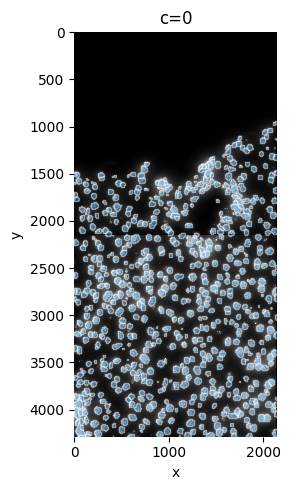

In [4]:
hp.sh.vectorize(
    sdata, labels_layer="segmentation_mask", output_layer="segmentation_mask_boundaries", overwrite=True
)  # convert the cell masks to a shapes layer.
hp.pl.plot_shapes(sdata, shapes_layer="segmentation_mask_boundaries", figsize=(5, 5))  # visualize the shapes.

Rechunk, so the labels layer and image layer have same spatial (('z'), 'y', 'x') chunk size.

In [5]:
# first make sure image layer and labels layer have the same chunk size

from harpy.image._image import _get_spatial_element

chunk_size = 1024
img_layer = "raw_image"
labels_layer = "segmentation_mask"

# rechunk
sdata = hp.im.add_image_layer(
    sdata,
    arr=_get_spatial_element(sdata, layer=img_layer).data.rechunk(chunk_size),
    output_layer=img_layer,
    overwrite=True,
)

sdata = hp.im.add_labels_layer(
    sdata,
    arr=_get_spatial_element(sdata, layer=labels_layer).data.rechunk(chunk_size),
    output_layer=labels_layer,
    overwrite=True,
)

2025-09-15 13:12:03,833 - harpy.image._manager - INFO - Writing results to layer 'raw_image'
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:71: UserWarning: Key `raw_image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
2025-09-15 13:12:03,840 - harpy.image._manager - INFO - Writing results to layer 'segmentation_mask'
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:88: UserWarning: Key `segmentation_mask` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Get the Dask array from the SpatialData object.

In [6]:
img_array = sdata[img_layer].data[:, None, ...]
mask_array = sdata[labels_layer].data[None, ...]

Sanity check.

In [7]:
assert img_array.chunksize[-2:] == mask_array.chunksize[-2:], "Chunk size in the spatial dimension should be equal."

Calculate the sum and the mean intensity for each cell using `hp.utils.RasterAggregator`.

In [8]:
aggregator = hp.utils.RasterAggregator(mask_dask_array=mask_array, image_dask_array=img_array)
df = aggregator.aggregate_stats(stats_funcs=("sum", "mean"))  # calculate sum and mean

In [9]:
display(df[0].head())  # -> sum of intensity for each cell
display(df[1].head())  # -> mean of intensity for each cell

,0,cell_ID
0,4.704252e+09,0
1,1.675982e+06,1
2,4.928528e+06,2
3,4.872624e+06,4
4,2.925965e+06,5


,0,cell_ID
0,617.251160,0
1,1576.652832,1
2,2127.116211,2
3,2222.912354,4
4,1646.575684,5


Sanity check.

In [10]:
import numpy as np

from harpy.utils._keys import _INSTANCE_KEY

# sanity check

cell_ID = 5

assert (
    sum(sdata[img_layer].data[0, ...][sdata[labels_layer].data == cell_ID].compute().astype(np.float32))
    == df[0][df[0][_INSTANCE_KEY] == cell_ID][0].item()
)

In [46]:
sdata

SpatialData object
├── Images
│     └── 'raw_image': DataArray[cyx] (1, 4288, 2144)
├── Labels
│     ├── 'segmentation_mask': DataArray[yx] (4288, 2144)
│     └── 'segmentation_mask_expanded': DataArray[yx] (4288, 2144)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     ├── 'filtered_low_counts_segmentation_mask_boundaries': GeoDataFrame shape: (33, 1) (2D shapes)
│     ├── 'filtered_segmentation_segmentation_mask_boundaries': GeoDataFrame shape: (8, 1) (2D shapes)
│     └── 'segmentation_mask_boundaries': GeoDataFrame shape: (657, 1) (2D shapes)
└── Tables
      ├── 'table_transcriptomics': AnnData (649, 96)
      ├── 'table_transcriptomics_cluster': AnnData (616, 87)
      └── 'table_transcriptomics_preprocessed': AnnData (616, 87)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), segmentation_mask_expanded (Labels), transcripts (Points), filtered_low_counts_segmentation_m

Alternatively using `harpy.tb.allocate_intensity`, ( which uses `harpy.utils.RasterAggregator`), and adds the results to the SpatialData object as an AnnData table.

In [57]:
sdata = hp.tb.allocate_intensity(
    sdata,
    img_layer="raw_image",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    mode="mean",
    obs_stats=["var", "skew"],
    calculate_center_of_mass=True,
)

display(sdata["table_intensities"])
display(sdata["table_intensities"].to_df().head())
display(sdata["table_intensities"].obs.head())
display(sdata["table_intensities"].obsm["spatial"][:5])  # -> center of mask

/Users/arnedf/VIB/harpy/src/harpy/utils/_aggregate.py:464: RuntimeWarning: invalid value encountered in divide
  skewness = (sum_third / count) / (np.sqrt(sum_square / count)) ** 3
2025-09-15 13:48:23,638 - harpy.utils._aggregate - WARNING - Replacing NaN values in 'skewness' with 0 for affected cells.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:286: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[_SPATIAL] = coordinates
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `table_intensities` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


AnnData object with n_obs × n_vars = 657 × 1
    obs: 'cell_ID', 'fov_labels', 'var_0', 'skew_0'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

channels,0
cells,
1_segmentation_mask_0932845e,1576.652832
2_segmentation_mask_0932845e,2127.116211
4_segmentation_mask_0932845e,2222.912354
5_segmentation_mask_0932845e,1646.575684
7_segmentation_mask_0932845e,2072.449463


,cell_ID,fov_labels,var_0,skew_0
cells,,,,
1_segmentation_mask_0932845e,1,segmentation_mask,801741.18750,0.000000
2_segmentation_mask_0932845e,2,segmentation_mask,293185.37500,0.020571
4_segmentation_mask_0932845e,4,segmentation_mask,320540.90625,0.000000
5_segmentation_mask_0932845e,5,segmentation_mask,168423.75000,0.931227
7_segmentation_mask_0932845e,7,segmentation_mask,461050.06250,0.161739


array([[2125.67638758,  961.25117592],
       [2068.32887354, 1036.62926198],
       [2016.3020073 , 1052.68385036],
       [2033.00844119, 1103.77940349],
       [1748.87579393, 1120.17431193]])

Calculate the quantiles.

In [21]:
df_quantiles = aggregator.aggregate_quantiles(depth=200, quantiles=[0.1, 0.3, 0.5, 0.7, 0.9])
len(df_quantiles)

5

In [22]:
display(df_quantiles[0].head())  # -> 0.1 quantile intensity for each cell and each channel
display(df_quantiles[-1].head())  # -> 0.9 quantile

,0,cell_ID
0,0.000000,1
1,1238.000000,2
2,1370.500000,4
3,1163.199951,5
4,1191.000000,7


,0,cell_ID
0,2644.000000,1
1,2727.000000,2
2,2804.899902,4
3,2179.000000,5
4,3047.000000,7


Compute radii and principal axes.

In [26]:
aggregator.aggregate_radii_and_axes(depth=200, calculate_axes=False)

,0,1,2,cell_ID
0,11.452508,7.496437,0.0,1
1,14.585308,12.705996,0.0,2
2,15.416794,11.370177,0.0,4
3,13.131853,10.793805,0.0,5
4,13.820557,8.377190,0.0,7
...,...,...,...,...
652,18.236729,8.628466,0.0,722
653,19.573774,5.277849,0.0,723
654,3.649892,2.696362,0.0,725
655,12.650456,0.298313,0.0,726


Custom aggregation of a channel.

In [ ]:
from skimage.measure import regionprops_table


def _calculate_intensity_mean(mask_block, image_block):
    # can be any callable, see the docstring of .aggregate_custom_channel
    table = regionprops_table(label_image=mask_block, intensity_image=image_block, properties=["intensity_mean"])
    return table["intensity_mean"]


intensity_mean = aggregator.aggregate_custom_channel(
    image=aggregator._image[0],
    mask=aggregator._mask,
    depth=200,
    fn=_calculate_intensity_mean,
)

Sanity check.

In [37]:
df = aggregator.aggregate_stats(
    stats_funcs=("mean")
)  # -> this is computationally more efficient than using aggregate_custom_channel.

assert np.allclose(df[0][0][1:].values.reshape(-1, 1), intensity_mean)

## Example 2: [Merscope data](https://info.vizgen.com/mouse-liver-data).

In [3]:
sdata = hp.datasets.merscope_segmentation_masks_example()

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Back the data to a zarr store for optimal processing.

In [ ]:
import os
import tempfile
from uuid import uuid4

from spatialdata import read_zarr

sdata.write(os.path.join(tempfile.tempdir, f"sdata_{uuid4()}.zarr"))
sdata = read_zarr(sdata.path)

In [ ]:
# first make sure image layer and labels layer have the same chunk size

from harpy.image._image import _get_spatial_element

chunk_size = 4096  # pick a chunksize that is not too small
img_layer = "clahe"
labels_layer = "segmentation_mask_full"

# rechunk
sdata = hp.im.add_image_layer(
    sdata,
    arr=_get_spatial_element(sdata, layer=img_layer).data.rechunk(chunk_size),
    output_layer=img_layer,
    overwrite=True,
)

sdata = hp.im.add_labels_layer(
    sdata,
    arr=_get_spatial_element(sdata, layer=labels_layer).data.rechunk(chunk_size),
    output_layer=labels_layer,
    overwrite=True,
)

In [6]:
img_array = sdata[img_layer].data[:, None, ...]
mask_array = sdata[labels_layer].data[None, ...]

assert img_array.chunksize[-2:] == mask_array.chunksize[-2:], "Chunk size in the spatial dimension should be equal."

In [ ]:
aggregator = hp.utils.RasterAggregator(mask_dask_array=mask_array, image_dask_array=img_array)
df = aggregator.aggregate_stats(stats_funcs=("sum"))  # takes ~2min on M2 mac.

In [10]:
df[0].head()  # -> sum of intensity for each channel and for each cell

,0,1,cell_ID
0,1.271207e+12,3.169670e+12,0
1,1.255469e+07,5.063005e+07,1025
2,1.141710e+05,4.061490e+05,1026
3,1.000944e+06,7.133834e+06,1027
4,1.000245e+07,2.617968e+07,1028


In [11]:
import numpy as np

from harpy.utils._keys import _INSTANCE_KEY

# sanity check

cell_ID = 1025

assert (
    sum(sdata[img_layer].data[0, ...][sdata[labels_layer].data == cell_ID].compute().astype(np.float32))
    == df[0][df[0][_INSTANCE_KEY] == cell_ID][0].item()
)

In [12]:
client.close()